<font size=3><strong>Intro</strong></font><br />
The objective of this article is to explain the process of conducting a back-test for a strategy based on technical indicators using Python. I will focus on employing a Bollinger Band-based strategy to generate signals and positions.

<font size=3><strong>Bollinger Reversal Strategy</strong></font><br />
Generate Bollinger Bands with a 20-day window, allowing for variations within plus or minus 2 standard deviations, based on the adjusted closing price. Buy when the price rises above the lower band from above, and maintain the position until the price surpasses the upper band from below on the subsequent occasion. Conversely, sell when the price crosses below the upper band from below, and retain the position until the price crosses above the lower band from the top in the next instance.

<font size=3><strong>Here are the steps to create your own back-testing code.</strong></font> <br />

- Import the essential libraries.
- Retrieve OHLCV data.
- Compute daily returns.
- Establish data columns tailored to the strategy.
- Develop strategy indicators.
- Generate signals and positions.
- Evaluate the outcomes.

<font size=3><strong>Step 1 : Import necessary libraries</strong></font>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')  # Ignore printing all warnings

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<font size=3><strong>Step 2 : Download OHLCV: (Open, High, Low, Close, Volume) data</strong></font></br>
I utilize the Yahoo Finance Python API, known as yfinance, to access the necessary data. It's worth noting that there are numerous open and free resources available for obtaining historical data, which is crucial for effectively backtesting your trading strategies.

In [2]:
# downloading historical necessary data for backtesting and analysis
start_date ='2015-01-01'
end_date = '2020-12-31'
ticker = '^NSEI'
df = yf.download(tickers=ticker, start = start_date, end = end_date) 

[*********************100%%**********************]  1 of 1 completed


<font size=3><strong>Step 3 : Calculate daily returns</strong></font></br>
In this step, we calculate daily returns to assess the performance in comparison to a buy and hold strategy, which serves as the benchmark. Essentially, this step aims to determine whether the strategy outperforms the straightforward approach of purchasing and holding the stock. A successful strategy should ideally yield superior results compared to a buy-and-hold strategy.

In [3]:
# calculating buy and hold strategy returns
df['buy_and_hold_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,buy_and_hold_returns
Date,,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900,NaN
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200,-0.002033
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,8127.350098,172800,-0.030422


<font size=3><strong>Step 4 : Create strategy-based data columns</strong></font></br>
The subsequent phase involves developing indicators that establish the criteria for the strategy. In the case of the Bollinger Band strategy, this entails working with the 20-day moving average, the standard deviation of the 20-day moving average, as well as the upper and lower bands derived from the standard deviation. These indicators are denoted as [MA_20days, std, upper_band, lower_band].


In [4]:
# creating bollinger band indicators
df['MA_20days'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['MA_20days'] + (2 * df['std'])   # 2*sigma deviation are used here
df['lower_band'] = df['MA_20days'] - (2 * df['std'])
df.drop(['Open','High','Low','Close'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Adj Close,Volume,buy_and_hold_returns,MA_20days,std,upper_band,lower_band
Date,,,,,,,
2020-12-23,13601.099609,458700,0.009960,13370.264990,267.181724,13904.628439,12835.901542
2020-12-24,13749.250000,471400,0.010834,13414.807471,251.132070,13917.071612,12912.543330
2020-12-28,13873.200195,403600,0.008975,13459.117480,249.854288,13958.826056,12959.408905
2020-12-29,13932.599609,439600,0.004272,13507.299951,243.181380,13993.662711,13020.937191
2020-12-30,13981.950195,380700,0.003536,13550.944971,246.256008,14043.456987,13058.432955


<font size=3><strong>Step 5 : Create strategy indicators</strong></font></br>
The subsequent stage represents the pivotal aspect of formulating the strategy. It encompasses the following key components:

Generating long and short signals as outlined in the strategy.
Substituting zeroes with forward fills to establish long and short positions.
Shifting positions by one step, indicating that return calculations are conducted from the close of one day to the close of the next day.
Signals essentially serve as indicators, signaling the required actions such as buying or selling. Positions, on the other hand, represent the holdings retained after executing buy or sell actions, which include going long or short in the market

In [13]:
# Long condition
df['signal']=0
df['signal'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

# Short condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
#df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['buy_and_hold_returns'] * (df['position'])

df.tail(5)

,Adj Close,Volume,buy_and_hold_returns,MA_20days,std,upper_band,lower_band,signal,position,strategy_returns,bnh_returns
Date,,,,,,,,,,,
2020-12-23,13601.099609,458700,0.009960,13370.264990,267.181724,13904.628439,12835.901542,0,-1.0,-0.009960,0.482461
2020-12-24,13749.250000,471400,0.010834,13414.807471,251.132070,13917.071612,12912.543330,0,-1.0,-0.010834,0.493294
2020-12-28,13873.200195,403600,0.008975,13459.117480,249.854288,13958.826056,12959.408905,0,-1.0,-0.008975,0.502269
2020-12-29,13932.599609,439600,0.004272,13507.299951,243.181380,13993.662711,13020.937191,0,-1.0,-0.004272,0.506541
2020-12-30,13981.950195,380700,0.003536,13550.944971,246.256008,14043.456987,13058.432955,0,-1.0,-0.003536,0.510077


In [14]:
df['signal'].value_counts()

 0    1357
-1      59
 1      55
Name: signal, dtype: int64

<font size=3><strong>Step 6 : Create signals and positions</strong></font></br>
The subsequent step entails comparing the strategy's performance by calculating cumulative returns. This process involves multiplying the positions with the daily returns on an element-wise basis.

Buy and hold returns: 0.5100773103336803
Strategy returns: -0.2104024060420321


<Axes: xlabel='Date'>

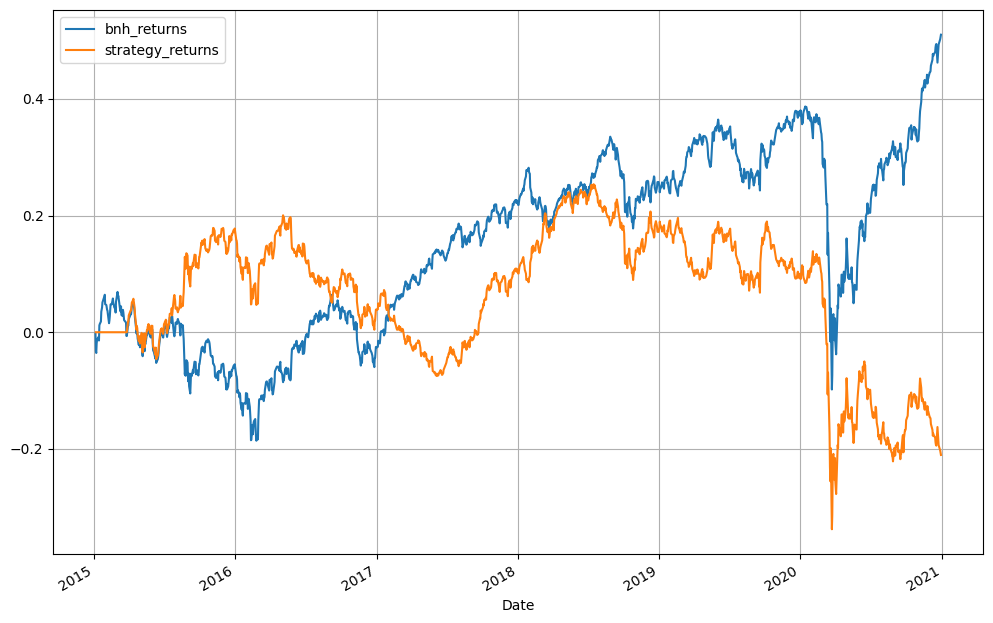

In [15]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['buy_and_hold_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['buy_and_hold_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

<font size=3><strong>Step 7 : Analyze results</strong></font></br>

In this stage, I employ Pyfolio, a Python library designed for the assessment of performance and risk in financial portfolios.






Start date,2015-01-02
End date,2020-12-30
Total months,70
,Backtest
Annual return,-5.1%
Cumulative returns,-26.2%
Annual volatility,17.8%
Sharpe ratio,-0.20
Calmar ratio,-0.11
Stability,0.15
Max drawdown,-46.9%


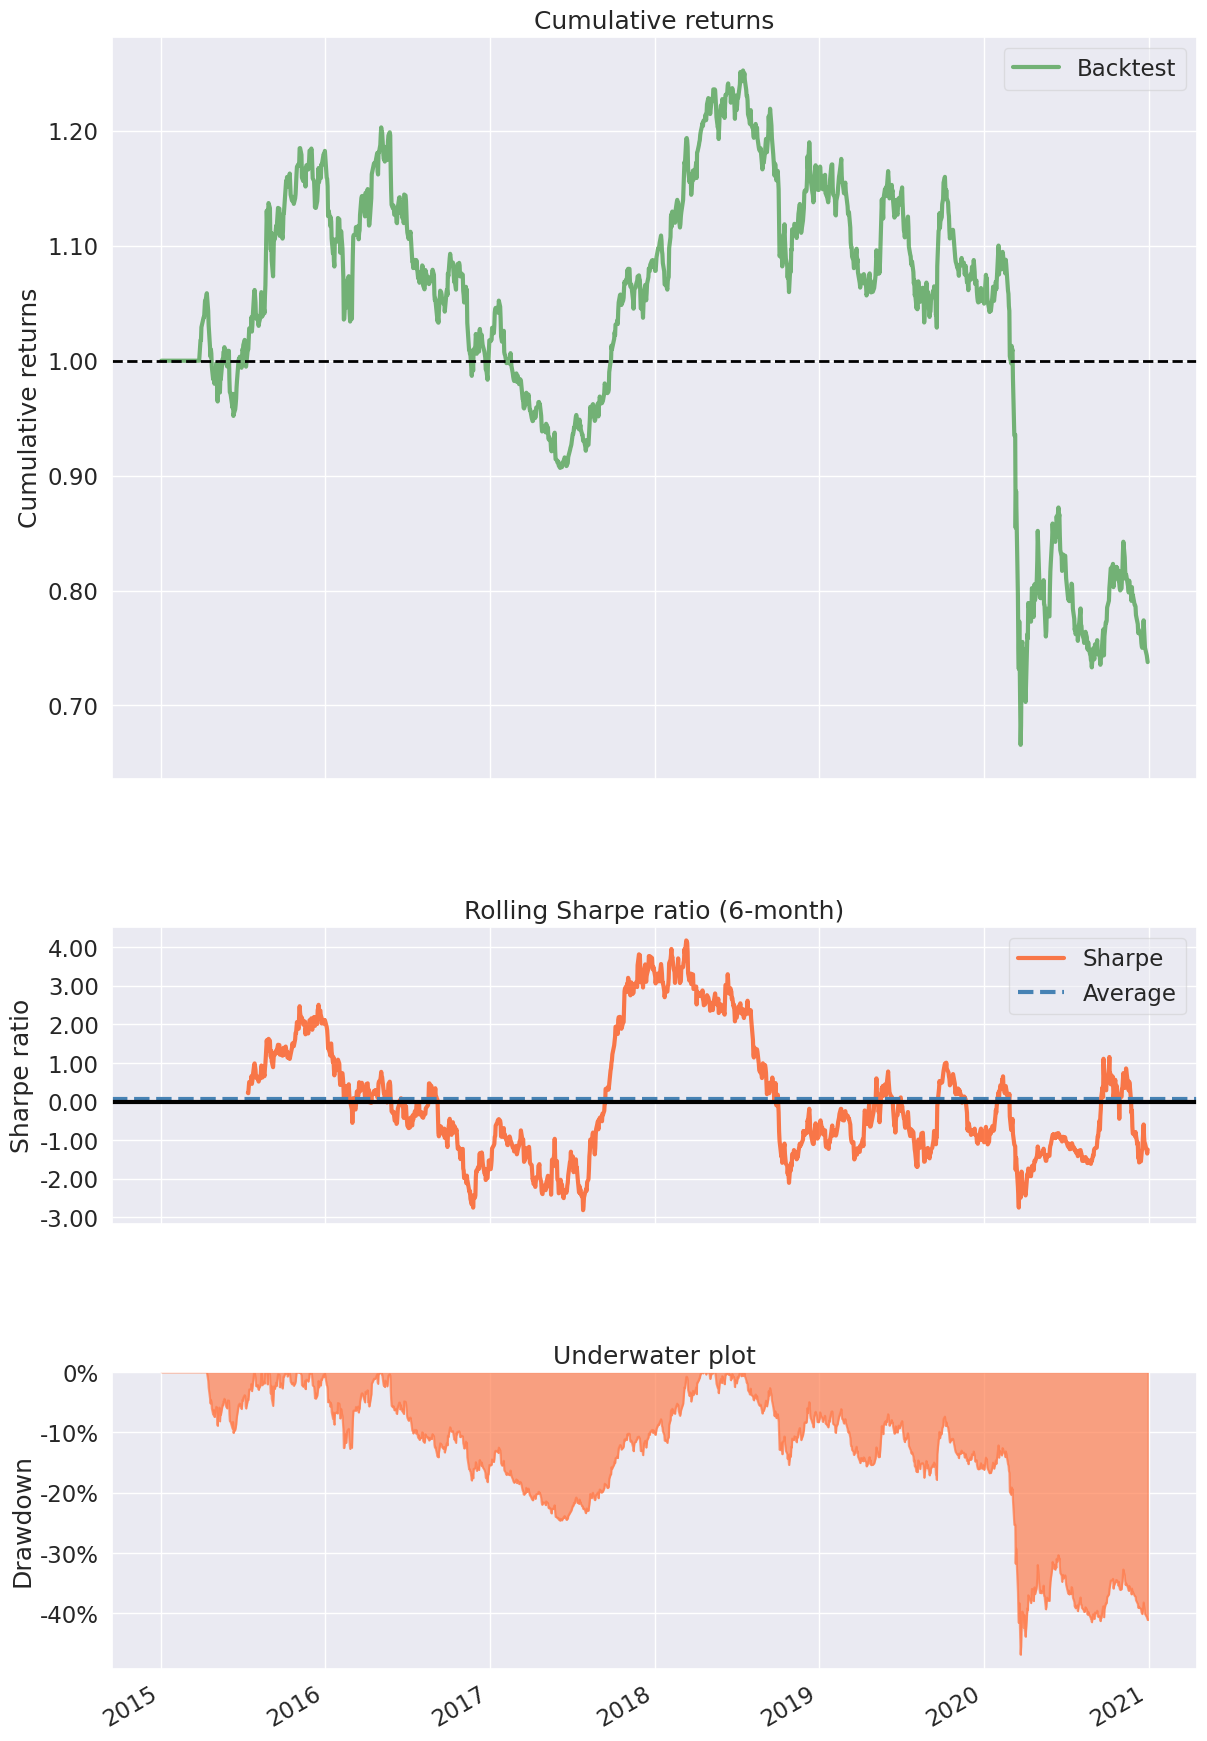

In [16]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())

<font size=3><strong>Comments</strong></font></br>
The results obtained through pyfolio provide a clear and comprehensible overview of the findings.

In the analysis of historical data, it was evident that the 'Bollinger band' strategy did not outperform the straightforward buy and hold approach. To illustrate, the cumulative daily returns for the buy and hold strategy reached 1.44 times the initial investment, whereas the Bollinger band strategy only yielded returns amounting to 0.37 times the initial investment.

However, it is essential to exercise caution when considering the transition from back-testing to live implementation, even if the former suggests promising returns. Several factors, such as transaction costs and stock price momentum, can introduce unforeseen risks into the equation.

To enhance a strategy's performance, one can explore optimization opportunities by assessing the returns associated with various strategy parameters. Additionally, the incorporation of different technical indicators in combination can generate more reliable signals, ultimately mitigating risks and enhancing overall performance.

For live strategies, it is advisable to implement safeguards like stop-loss mechanisms and kill switches to maintain control in case the strategy deviates from its intended course. These precautions are vital for safeguarding investments and minimizing potential losses.